## Import packages

In [1]:
import os
import pandas as pd
import numpy as np
from skimage import io
from tqdm.notebook import tqdm
import pickle

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
%matplotlib inline
sns.set()

import tensorflow as tf
import keras
from keras.losses import categorical_crossentropy
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,recall_score,precision_score,accuracy_score,f1_score
from sklearn.utils import class_weight
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
def pickle_file(output_file_name, object_to_pickle):
    with open(output_file_name, 'wb') as out_file:
        pickle.dump(object_to_pickle, out_file)

def unpickle_file(file_name):
    with open(file_name, 'rb') as in_file:
        return pickle.load(in_file)

## Load dataset

**Invasive Ductal Carcinoma (IDC)** is the most common form of breast cancer. Accurately identifying and categorizing breast cancer subtypes is an important clinical task, and automated methods can be used to **save time** and **reduce error**.

The original dataset can be downloaded from [this Kaggle page](https://www.kaggle.com/paultimothymooney/breast-histopathology-images).
My work is largely inspired from [Allunia's kernel](https://www.kaggle.com/allunia/breastcancer). 

The dataset  is composed of a **279 patients**, for which I had a set of **histological images** (50x50 pixels each), that were either **labeled as benign or malignant**. Each image was associated to an x and y coordinate, meaning that they could be plotted together to reconstitute a slide of patient's breast tissue.

In [20]:
base_path = 'breast-histopathology-images/IDC_regular_ps50_idx5'
patient_folders = os.listdir(base_path)

image_names = []
image_paths = []

for folder in patient_folders:
    for i in range(2):
        folder_image_names = os.listdir(f'{base_path}/{folder}/{i}')
        image_names += folder_image_names
        image_paths += [os.path.join(f'{base_path}/{folder}/{i}',image) for image in folder_image_names]
        
patient_id = [i.split('_')[0] for i in image_names]
x_coord = [i.split('_')[2].strip('x') for i in image_names]
y_coord = [i.split('_')[3].strip('y') for i in image_names]
target = [i.split('_')[4].strip('class.png') for i in image_names]

df = pd.DataFrame([patient_id,x_coord,y_coord,target,image_paths],
                  index=['patient_id','x_coord','y_coord','target','image_path']).T

for col in ['patient_id','x_coord','y_coord','target']:
    df[col] = df[col].astype(int)

## Exploratory Data Analysis

A large part of the work was to make the proper visualizations to get a good understanding of the dataset. To do do, I had to work deeply with images (combining patches to recreate patient tissues, highlighting malignant areas, etc.).

#### 1. Big numbers

In [4]:
print(f'Number of patients: {df.patient_id.nunique()}')
print(f'Number of images: {df.shape[0]}')
patches_nb = df.target.value_counts()
patches_distrib = (df.target.value_counts()/df.shape[0]*100).round(1)
print('Distribution of patches:')
print(f'- Malignant: {patches_distrib[0]}% ({patches_nb[0]} images)')
print(f'- Benign: {patches_distrib[1]}% ({patches_nb[1]} images)')

Number of patients: 279
Number of images: 277524
Distribution of patches:
- Malignant: 71.6% (198738 images)
- Benign: 28.4% (78786 images)


#### 2. Patches per patient

**The dataset is highly imbalanced**: regarding the number of malignant patches available per patient, the proportion of malignant patches per patients indicating different levels of severity, and the overall proportion total patches being benign (78%) or malignant (22%). It means that while building our train, validation and test sets, we should make sure to have a good representation of 1. patient severity levels and 2. malignant patches volumes.

Text(0.5, 1.0, 'Which proportion of total patches are malignant?')

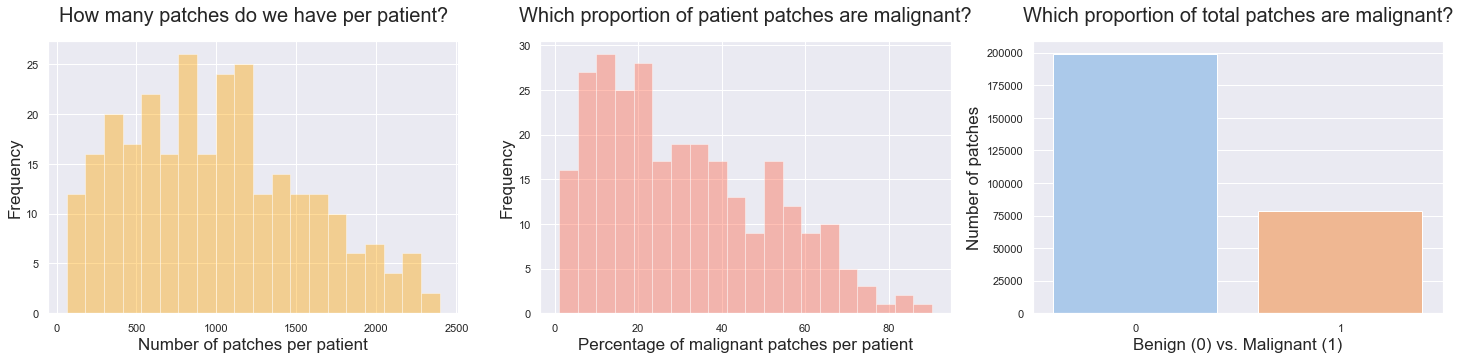

In [5]:
fig,ax = plt.subplots(1,3,figsize=(25,5))

sns.distplot(df.groupby('patient_id').size(),ax=ax[0],kde=False,bins=20,color='Orange')
ax[0].set_xlabel('Number of patches per patient',fontsize=17)
ax[0].set_ylabel('Frequency',fontsize=17)
ax[0].set_title('How many patches do we have per patient?',fontsize=20,pad=20)

cancer_per_df = pd.crosstab(df.patient_id,df.target,normalize='index')[1].map(lambda x:round(x*100,2))
sns.distplot(cancer_per_df,ax=ax[1],kde=False,bins=20,color='Tomato')
ax[1].set_xlabel('Percentage of malignant patches per patient',fontsize=17)
ax[1].set_ylabel('Frequency',fontsize=17)
ax[1].set_title('Which proportion of patient patches are malignant?',fontsize=20,pad=20)

sns.countplot(df.target,ax=ax[2],palette='pastel')
ax[2].set_xlabel('Benign (0) vs. Malignant (1)',fontsize=17)
ax[2].set_ylabel('Number of patches',fontsize=17)
ax[2].set_title('Which proportion of total patches are malignant?',fontsize=20,pad=20)

#### 3. Visualization of patches

**Color seems to be a decisive information to spot cancerous patches**: they tend to be darker, and more purple than benign ones. But as some benign patches also appear to be dark, **color does not seem to be the only feature to consider in image classification**. Still, to build the model, it makes sense to keep images in  a RGB format (vs. grayscale that would loose significant info).

In [6]:
malignant_tissue = np.random.choice(df[df.target==1].image_path.values, size=100, replace=False)
benign_tissue = np.random.choice(df[df.target==0].image_path.values, size=100, replace=False)

##### 3.1. Malignant patches

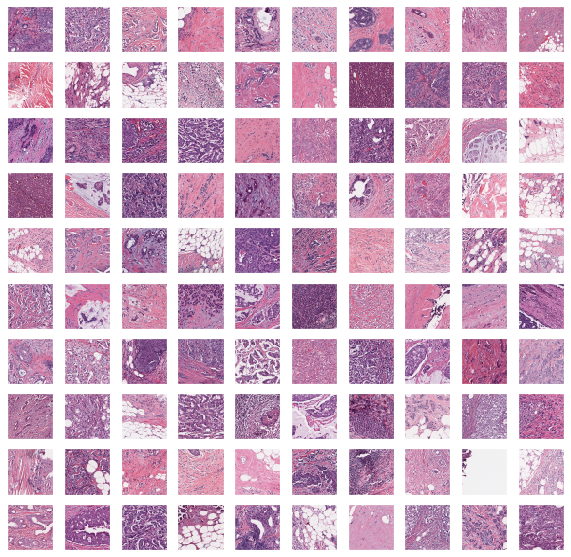

In [7]:
fig,ax=plt.subplots(10,10,figsize=(10,10))
for row in range(10):
    for col in range(10):
        image = io.imread(malignant_tissue[row+col*10])
        ax[row,col].imshow(image)
        ax[row,col].grid(False)
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])

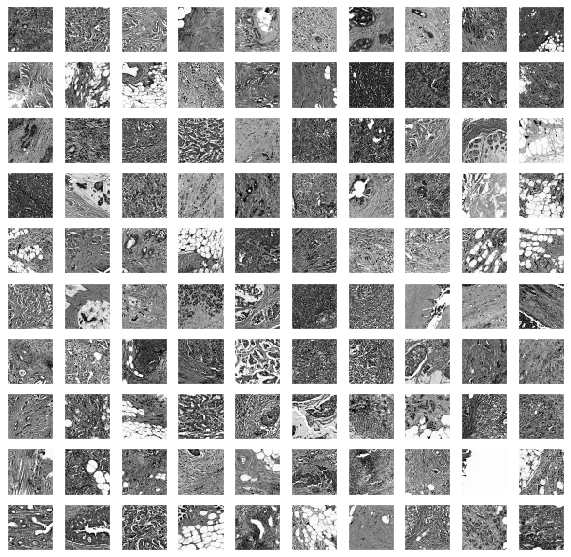

In [8]:
fig,ax=plt.subplots(10,10,figsize=(10,10))
for row in range(10):
    for col in range(10):
        image = io.imread(malignant_tissue[row+col*10],as_gray=True)
        ax[row,col].imshow(image,cmap='gray')
        ax[row,col].grid(False)
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])

##### 3.2. Benign patches

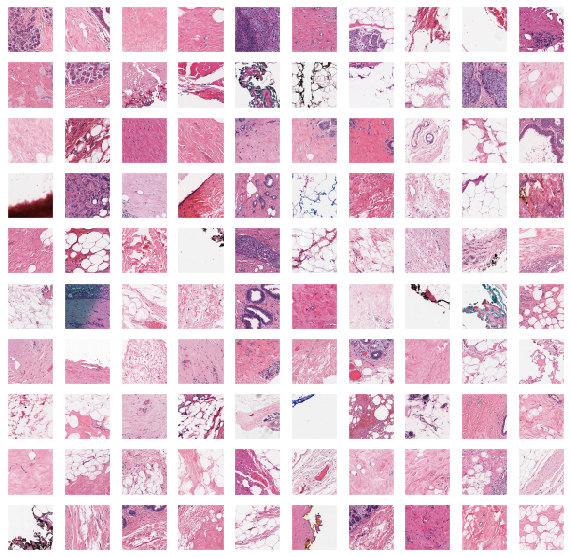

In [9]:
fig,ax=plt.subplots(10,10,figsize=(10,10))
for row in range(10):
    for col in range(10):
        image = io.imread(benign_tissue[row+col*10])
        ax[row,col].imshow(image)
        ax[row,col].grid(False)
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])

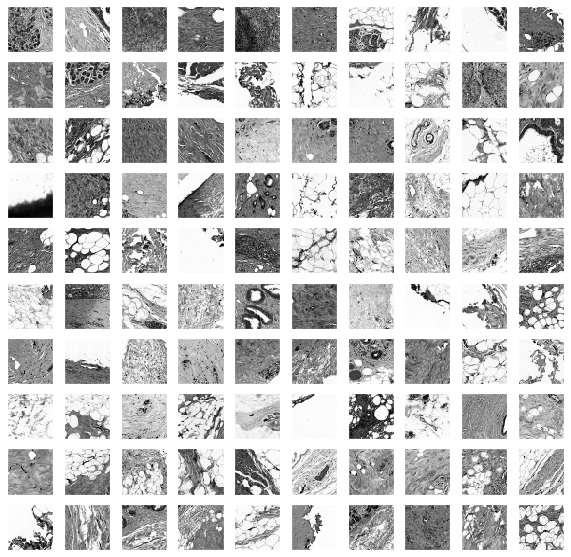

In [10]:
fig,ax=plt.subplots(10,10,figsize=(10,10))
for row in range(10):
    for col in range(10):
        image = io.imread(benign_tissue[row+col*10],as_gray=True)
        ax[row,col].imshow(image,cmap='gray')
        ax[row,col].grid(False)
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])

##### 3.3. Patches location

**Malignant patches are often grouped** into localized tumors.

In [11]:
patient_sample = np.random.choice(df.patient_id.unique(),size=18,replace=False)

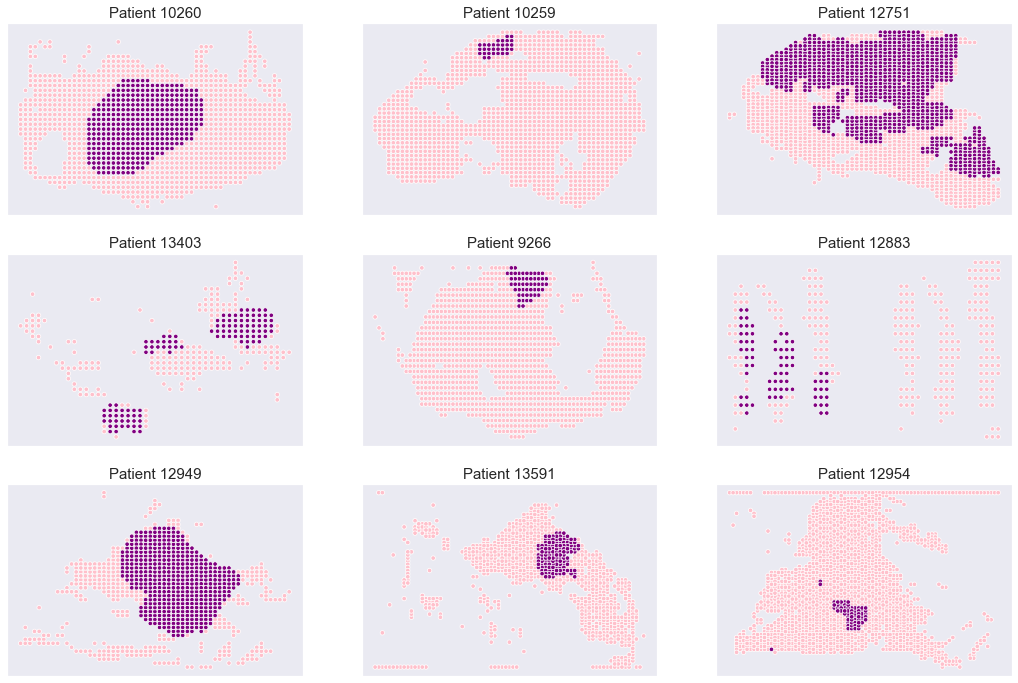

In [12]:
fig,ax=plt.subplots(3,3,figsize=(18,12))
for row in range(3):
    for col in range(3):
        patient_id = patient_sample[row*3+col]
        patient_df = df[df.patient_id==patient_id]
        sns.scatterplot(data=patient_df,x='x_coord',y='y_coord',
                                    hue='target',palette=['pink','purple'],s=20,ax=ax[row,col])
        ax[row,col].set_title(f'Patient {patient_id}',fontsize=15)
        ax[row,col].legend().set_visible(False)
        ax[row,col].set_xlabel(None)
        ax[row,col].set_ylabel(None)
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])
        ax[row,col].grid(False)

##### 3.4. Assembled patches

In [3]:
def get_patient_image(df,patient_id):
    """
    Function reconstituting the full patient image by combining individual patches.
    """
    df_patient = df[df.patient_id==patient_id]
    max_coord = np.max([df_patient.y_coord,df_patient.x_coord])
    patient_img = 255*np.ones([max_coord+50,max_coord+50,3]).astype(np.uint8)
    for i in range(len(df_patient.image_path)):
        try:
            looped_img = io.imread(df_patient.image_path.values[i])
            looped_x = df_patient.x_coord.values[i]
            looped_y = df_patient.y_coord.values[i]
            patient_img[looped_y:looped_y+50,looped_x:looped_x+50,:]=looped_img
        except:
            pass
    return np.flip(patient_img,axis=0)

def get_patient_mask(df,patient_id,mask_item):
    """
    Function creating a blue-colored mask
    over patches that are malignant (if mask_item=target),
    or predicted-malignant (if mask=target_pred).
    """
    df_patient = df[df.patient_id==patient_id]
    max_coord = np.max([df_patient.y_coord,df_patient.x_coord])
    patient_mask = 255*np.ones([max_coord+50,max_coord+50,3]).astype(np.uint8)
    for i in range(len(df_patient.image_path)):
        if df_patient[mask_item].values[i]==1:
            looped_x = df_patient.x_coord.values[i]
            looped_y = df_patient.y_coord.values[i]
            patient_mask[looped_y:looped_y+50,looped_x:looped_x+50,0]=0*np.ones([50,50]).astype(np.uint8)
    return np.flip(patient_mask,axis=0)

def get_highlighted_tissue(df,patient_id,mask_item):
    """
    Function superposing patient image and patient mask.
    """
    alpha = 0.78
    patient_img = get_patient_image(df,patient_id)
    patient_mask = get_patient_mask(df,patient_id,mask_item)
    return (patient_mask*(1.0-alpha)+patient_img*alpha).astype('uint8')

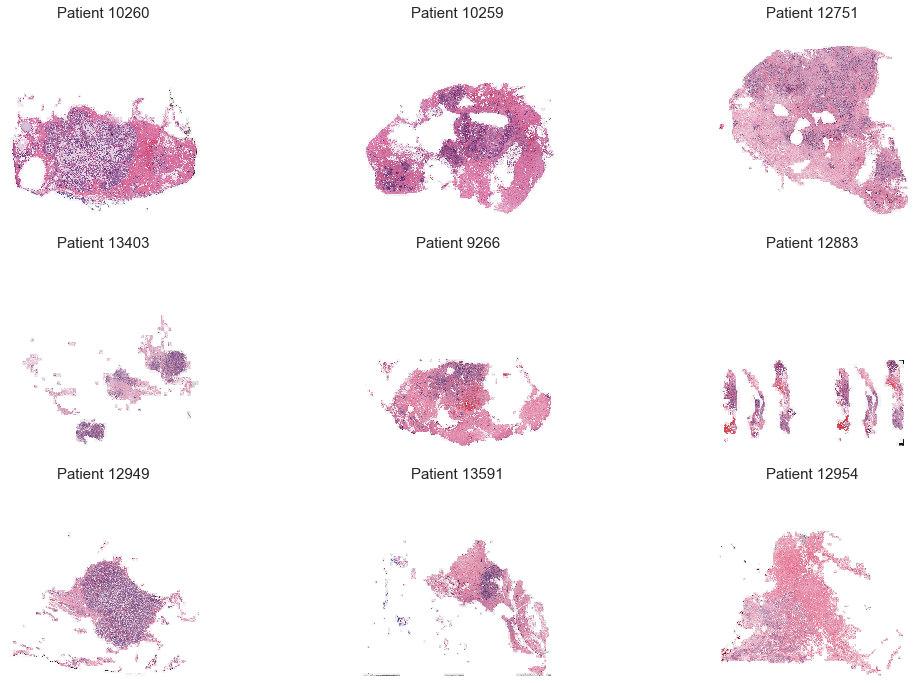

In [14]:
fig,ax=plt.subplots(3,3,figsize=(18,12))
for row in range(3):
    for col in range(3):
        patient_id = patient_sample[row*3+col]
        patient_img = get_patient_image(df,patient_id)
        ax[row,col].imshow(patient_img)
        ax[row,col].set_title(f'Patient {patient_id}',fontsize=15)
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])
        ax[row,col].grid(False)

##### 3.5. First insights on classification challenges (highlighting cancerous patches)

On the two first patients, cancerous areas could be easily spotted (they are associated to darkest areas), but this is not the case of the two last images.

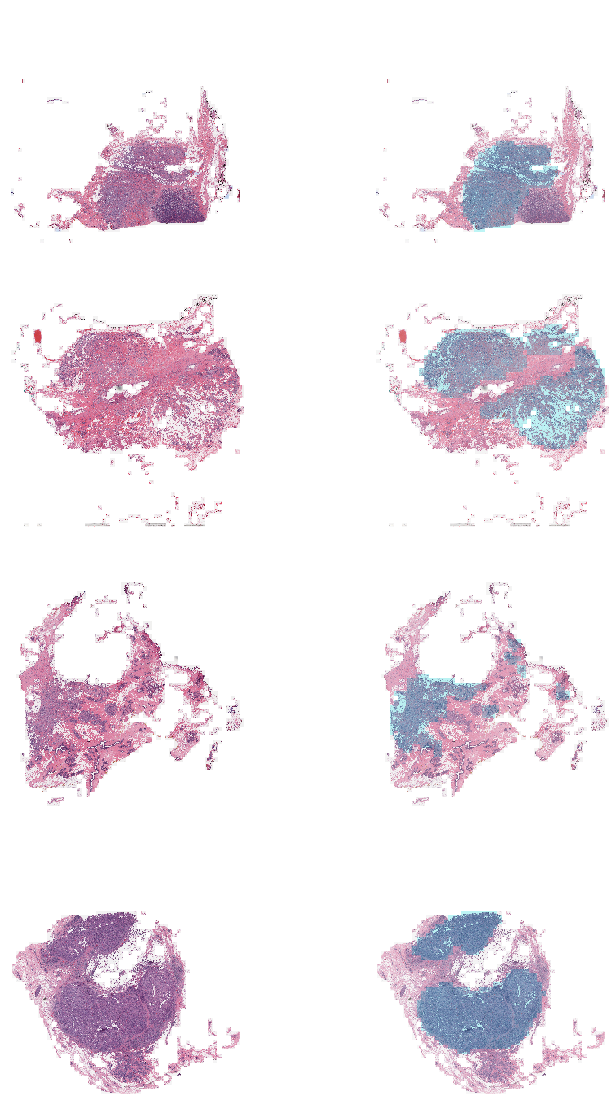

In [15]:
patient_ids = [12242,13616,15840,9250]
nrows=len(patient_ids)

fig,ax=plt.subplots(nrows,2,figsize=(12,5*nrows))

for i in range(nrows):
    
    patient_id=patient_ids[i]

    ax[i,0].imshow(get_patient_image(df,patient_id))
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    ax[i,0].grid(False)

    ax[i,1].imshow(get_highlighted_tissue(df,patient_id,mask_item='target'))
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])
    ax[i,1].grid(False)

## Deep learning

The goal of our model is to **classify patches between *benign* and *malignant***.

 - The **first risk** that we can encounter is that **the model classifies a patch as non-cancerous, while it actually is**: this is the most dangerous error that our model could make, as it would mean that the patient would go back home without any appropriate treatment. For this reason, **our primary KPI will be Recall**  (*objective: minimize False Negatives*).
 - The **second risk** that we can encounter is that **the model classifies a patch as cancerous, while it is not**. In this case, the risk is limited, as a doctor will still check the patient folder, and will be able to exclude the bias. However, we should save doctors time as much as we can: this is the reason why **our secondary KPI will be the F1-Score** (*objective: strike a balance between False Positives and False Negatives*).

#### 1. Prepare data

In [4]:
def split_by_cancer_level(df,test_size):
    """
    Function returning a (df_train, df_test) tuple. Each df contains distincts patients,
    with a distribution of cancerous patches that is representative of the original df.
    test_size: proportion of the original df that will be retrieved in df_test
    """
    cancer_per_df = pd.crosstab(df.patient_id,df.target,normalize='index')[1].map(lambda x:round(x*100,2))
    cancer_level_df = pd.cut(cancer_per_df,bins=5,labels=['1','2','3','4','5'])
    cancer_level_df = cancer_level_df.to_frame().reset_index().rename(columns={1:'cancer_level'})
    patients_tuple = train_test_split(cancer_level_df,
                                      test_size=test_size,
                                      stratify=cancer_level_df.cancer_level,
                                      random_state=42)
    patients_train = patients_tuple[0].patient_id.values
    patients_test = patients_tuple[1].patient_id.values
    df_train = df[df.patient_id.isin(patients_train)].reset_index(drop=True)
    df_test = df[df.patient_id.isin(patients_test)].reset_index(drop=True)
    return df_train, df_test

def load_images(df,color):
    """
    Function replacing image paths by actual image matrices,
    and dropping rows on which images do not match the (50,50) standard dimension.
    color=True will load RGB images, while color=False will load grayscale images.
    The optimal process would have been to scale pixel values between 0 and 1
    (by dividing all of them by 255), but it would have taken too much memory.
    """
    drop_index = []
    df_img = df.copy()
    for i in tqdm(df.index):
        if color:
            image = io.imread(df_img.image_path[i])
            if image.shape!=(50,50,3):
                drop_index.append(i)
            else:
                df_img.image_path[i] = image
        else:
            image = io.imread(df_img.image_path[i],as_gray=True)
            if image.shape!=(50,50):
                drop_index.append(i)
            else:
                df_img.image_path[i] = image           
    df_img = df_img.drop(drop_index).reset_index(drop=True)
    return df_img

def extract_sets(df,flat):
    """
    Function extracting:
    - X: image array
    - y: target class (0: benign, 1: malignant)
    - patch_info: df with patient_id, x_coord and y_coord
    from a df on which images have been previously added.
    """
    if flat:
        X = df.iloc[:,4:]
    else:
        X = np.concatenate([df.image_path.values.tolist()])
    y = df.iloc[:,3]
    patch_info = df.iloc[:,:3]
    return X, y, patch_info

In [6]:
#df_img_rgb = load_images(df,color=True)
df_img_rgb = unpickle_file('df-backups/df_img_rgb')

In [7]:
df_train, df_test = split_by_cancer_level(df_img_rgb,test_size=0.2)
df_train, df_val = split_by_cancer_level(df_train,test_size=0.2)

X_train, y_train, train_patch_info = extract_sets(df_train,flat=False)
X_val, y_val, val_patch_info = extract_sets(df_val,flat=False)
X_test, y_test, test_patch_info = extract_sets(df_test,flat=False)

In [5]:
def visualize_sets_distribution(df_train,df_val,df_test):
    """Function displaying the disribution of train,
    validation and test sets between benign and malignant patches."""
    fig,ax = plt.subplots(1,3,figsize=(25,5))

    sns.countplot(df_train.target,ax=ax[0],palette='Reds')
    ax[0].set_xlabel('Benign (0) vs. Malignant (1)',fontsize=17)
    ax[0].set_ylabel('Number of patches',fontsize=17)
    ax[0].set_title(f'Train patches ({df_train.patient_id.nunique()} patients)',fontsize=20,pad=20)

    sns.countplot(df_val.target,ax=ax[1],palette='Blues')
    ax[1].set_xlabel('Benign (0) vs. Malignant (1)',fontsize=17)
    ax[1].set_ylabel('Number of patches',fontsize=17)
    ax[1].set_title(f'Validation patches ({df_val.patient_id.nunique()} patients)',fontsize=20,pad=20)

    sns.countplot(df_test.target,ax=ax[2],palette='Greens')
    ax[2].set_xlabel('Benign (0) vs. Malignant (1)',fontsize=17)
    ax[2].set_ylabel('Number of patches',fontsize=17)
    ax[2].set_title(f'Test patches ({df_test.patient_id.nunique()} patients)',fontsize=20,pad=20)
    
    fig.savefig('graphs/CNN-sets-distribution.png')

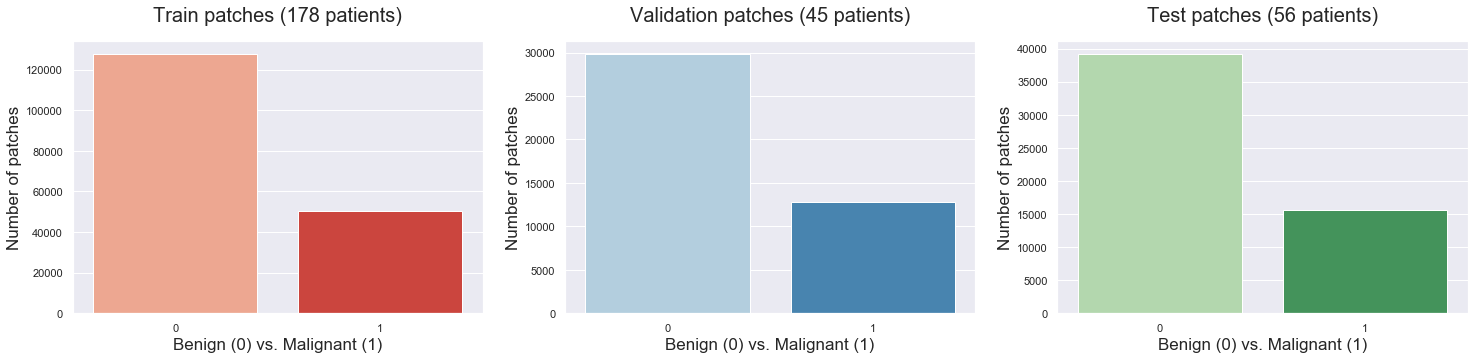

In [28]:
visualize_sets_distribution(df_train,df_val,df_test)

#### 2. Build the neural network

In [9]:
Y_train = to_categorical(y_train,2)
Y_val = to_categorical(y_val,2)
Y_test = to_categorical(y_test,2)

In [10]:
model = Sequential()

#Convolutional layer
model.add(Conv2D(32,(3,3),activation='relu',strides=2,input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Convolutional layer
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Flatten layer
model.add(Flatten())

#Fully-connected layer
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

#Choose the loss and optimizer functions
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

#Set-up call-backs to find out the best number of epoch
cp = ModelCheckpoint('saved-models/CNN_best_model_Adadelta.h5',
                    monitor='val_accuracy',
                    verbose=1,
                    save_best_only=True)

In [11]:
#Fit the model
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    batch_size=300,
                    epochs=20,
                    verbose=1,
                    callbacks=[cp])

pickle_file('saved-models/CNN_best_model_Adadelta_history',history)

Train on 177875 samples, validate on 42597 samples
Epoch 1/20
177875/177875 [==============================] - 130s 730us/step - loss: 1.1363 - accuracy: 0.7190 - val_loss: 0.5340 - val_accuracy: 0.7501

Epoch 00001: val_accuracy improved from -inf to 0.75008, saving model to saved-models/CNN_best_model_Adadelta.h5
Epoch 2/20
177875/177875 [==============================] - 108s 610us/step - loss: 0.4763 - accuracy: 0.7710 - val_loss: 0.4283 - val_accuracy: 0.8240

Epoch 00002: val_accuracy improved from 0.75008 to 0.82403, saving model to saved-models/CNN_best_model_Adadelta.h5
Epoch 3/20
177875/177875 [==============================] - 109s 615us/step - loss: 0.4435 - accuracy: 0.7894 - val_loss: 0.4586 - val_accuracy: 0.8165

Epoch 00003: val_accuracy did not improve from 0.82403
Epoch 4/20
177875/177875 [==============================] - 107s 602us/step - loss: 0.4237 - accuracy: 0.8113 - val_loss: 0.4688 - val_accuracy: 0.8233

Epoch 00004: val_accuracy did not improve from 0.8240

In [12]:
#Load best model
best_model = load_model('saved-models/CNN_best_model_Adadelta.h5')

#### 3. Visualize model learning rates

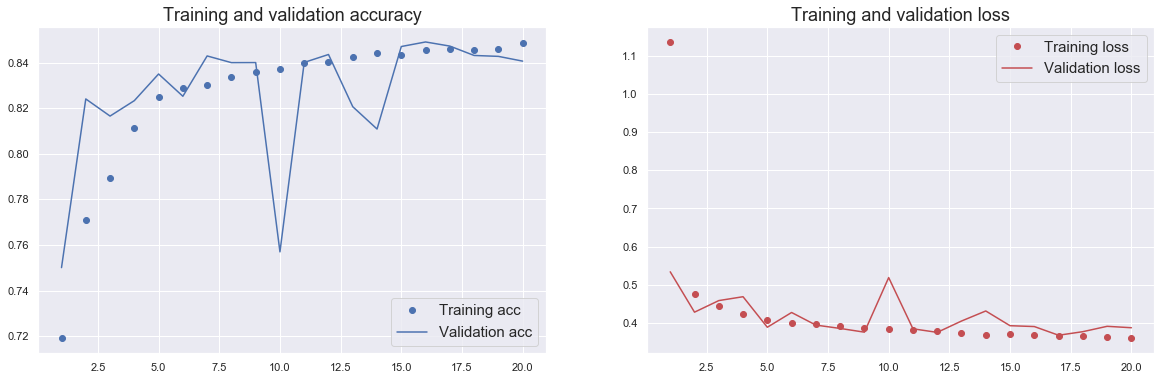

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

fig,ax=plt.subplots(1,2,figsize=(20,6))

ax[0].plot(epochs, acc, 'bo', label='Training acc')
ax[0].plot(epochs, val_acc, 'b', label='Validation acc')
ax[0].set_title('Training and validation accuracy',fontsize=18)
ax[0].legend(loc='lower right',fontsize=15)

ax[1].plot(epochs, loss, 'bo', label='Training loss',color='r')
ax[1].plot(epochs, val_loss, 'b', label='Validation loss',color='r')
ax[1].set_title('Training and validation loss',fontsize=18)
ax[1].legend(loc='upper right',fontsize=15)

fig.savefig('graphs/CNN-accuracy-loss-evolution')

#### 4. Check model scores

In [14]:
def get_prediction_at_given_threshold(t,model,X_test):
    """
    Function getting y_pred for a specific threshold.
    """
    classes_proba = model.predict(X_test)
    y_pred = np.where(classes_proba>=t,1,0)[:,1]
    return y_pred

def plot_perf_at_each_threshold(model,X_test):
    """
    Function plotting recall and f1-scores given threshold levels.
    """
    recall = []
    f1 = []
    threshold = np.arange(0.05,1,0.05)
    for t in tqdm(threshold):
        y_pred = get_prediction_at_given_threshold(t,model,X_test)
        recall.append(round(recall_score(y_test,y_pred)*100,2))
        f1.append(round(f1_score(y_test,y_pred)*100,2))
        
    threshold = np.arange(0.05,1,0.05)
    fig,ax=plt.subplots(figsize=(15,6))
    ax.plot(threshold,recall,'bo',label='Recall')
    ax.plot(threshold,f1,'bo',label='F1-Score',color='r')
    ax.set_title('Model performance given threshold levels',fontsize=15)
    ax.set_xlabel('Threshold level',fontsize=13)
    ax.set_ylabel('Performance',fontsize=13)
    ax.set_xticks(np.arange(0,1,0.05))
    ax.legend(loc='best',fontsize=13)

    fig.savefig('threshold-selection.png')

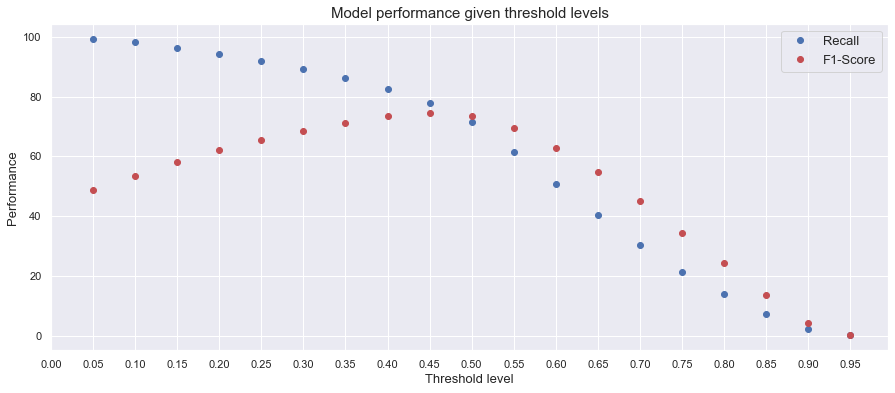

In [15]:
plot_perf_at_each_threshold(best_model,X_test)

Text(0.5, 1, 'Confusion matrix')

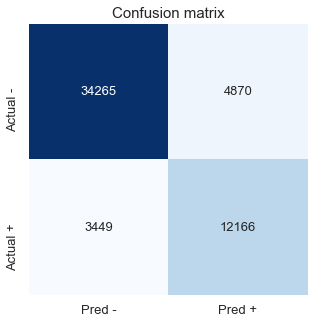

In [16]:
y_pred = get_prediction_at_given_threshold(0.45,best_model,X_test)

conf_mat = confusion_matrix(y_test,y_pred)

fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat,annot=True,annot_kws={'fontsize':13},cmap='Blues',fmt='g',cbar=False,ax=ax)
ax.set_ylim(2,0)
ax.set_yticklabels(['Actual -','Actual +'],fontsize=13)
ax.set_xticklabels(['Pred -','Pred +'],fontsize=13)
ax.set_title('Confusion matrix',fontsize=15)

In [17]:
print('Accuracy:',round(accuracy_score(y_test,y_pred)*100,2))
print('Recall:',round(recall_score(y_test,y_pred)*100,2))
print('Precision:',round(precision_score(y_test,y_pred)*100,2))
print('F1-Score:',round(f1_score(y_test,y_pred)*100,2))

Accuracy: 84.81
Recall: 77.91
Precision: 71.41
F1-Score: 74.52


#### 5. Visualize model performance on the test set

In [18]:
def get_cancer_proba_heatmap(df,patient_id):
    """
    Function creating a heatmap of cancer probabilities based on model outputs.
    Input df should have the following columns:
    patient_id, x_coord, y_coord, target, cancer_proba
    """
    df_patient = df[df.patient_id==patient_id]
    max_coord = np.max([df_patient.y_coord,df_patient.x_coord])
    patient_mask = np.zeros([max_coord+50,max_coord+50]).astype(np.uint8)
    for i in range(len(df_patient.cancer_proba)):
        looped_x = df_patient.x_coord.values[i]
        looped_y = df_patient.y_coord.values[i]
        looped_proba = df_patient.cancer_proba.values[i]
        patient_mask[looped_y:looped_y+50,looped_x:looped_x+50]=looped_proba*100*np.ones([50,50]).astype('uint8')
    return np.flip(patient_mask,axis=0)

def visualize_model_results(df_plot):
    """
    Function plotting the outputs the 3 following functions next to each other:
    - get_patient_image
    - get_highlighted_tissue
    - get_cancer_proba_heatmap
    """                        
    patient_id_lst=df_plot.patient_id.unique()[:10]

    fig,ax=plt.subplots(10,3,figsize=(20,5*10))

    for i in tqdm(range(10)):

        patient_id=patient_id_lst[i]

        ax[i,0].imshow(get_patient_image(df_plot,patient_id))
        ax[i,0].set_xticks([])
        ax[i,0].set_yticks([])
        ax[i,0].set_title(f'Patient {patient_id} - Breast tissue',fontsize=15)
        ax[i,0].grid(False)

        ax[i,1].imshow(get_highlighted_tissue(df_plot,patient_id,mask_item='target'))
        ax[i,1].set_xticks([])
        ax[i,1].set_yticks([])
        ax[i,1].set_title(f'Actual cancer tissue colored blue',fontsize=15)
        ax[i,1].grid(False)
        
        image = ax[i,2].imshow(get_cancer_proba_heatmap(df_plot,patient_id),cmap='YlOrRd',vmin=0,vmax=100)
        divider = make_axes_locatable(ax[i,2])
        cax = divider.append_axes('right',size='5%',pad=0.1)
        plt.colorbar(image, ax=ax[i,2], cax=cax, orientation='vertical')
        ax[i,2].set_xticks([])
        ax[i,2].set_yticks([])
        ax[i,2].set_title(f'Cancer probability',fontsize=15)
        ax[i,2].grid(False)

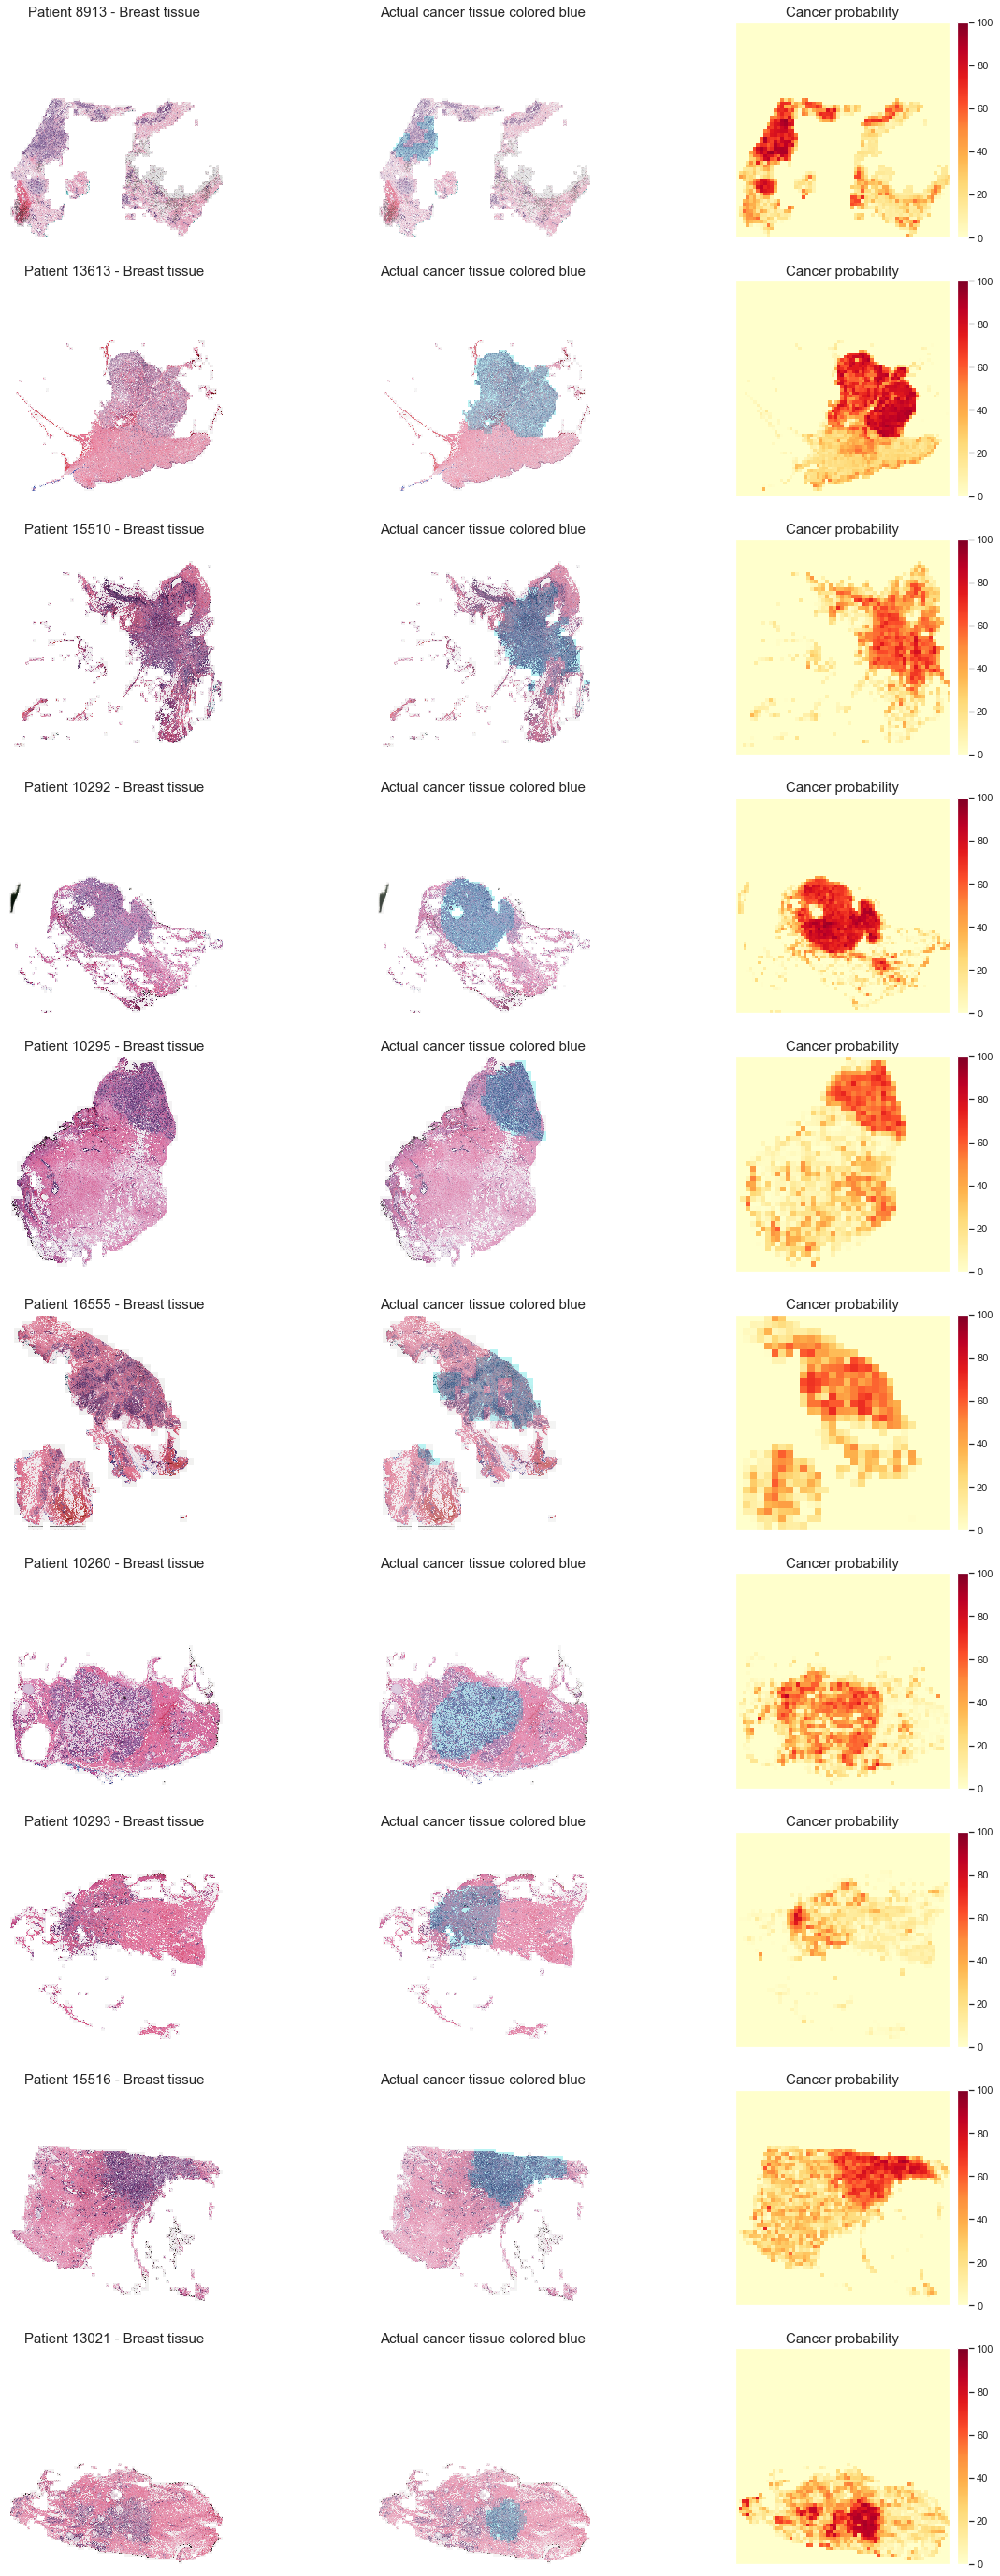

In [21]:
df_plot_test = test_patch_info.copy()
df_plot_test = pd.merge(df_plot_test,df,on=['patient_id','x_coord','y_coord'])
df_plot_test['cancer_proba'] = best_model.predict(X_test)[:,1]

visualize_model_results(df_plot_test)

## Machine Learning

During a previous phase of this project, several approaches were tested on a 10% sample of the dataset:
- Between all Machine Learning models, **CatBoostClassifier** is by far the best performing one.
- The model performs better on **RGB images** than grayscale ones.
- The use of **dimensionality reduction techniques (PCA)** did not improve model performance.
- Combining **image coordinates** with predicted probabilities does not help the model (tendency to over-predict).
- We did not notice a significant performance increase while doing **affine transformations** on images (flip, rotate, shear, etc.)

All these cul-de-sac let us think that **we might have reached the limits of traditional Machine Learning models**. As a final step, we decided to re-train the "classic" CatBoostClassifier of the whole database, so that we can compare its overall performance with Convolutional Neural Networks.

#### 1. Prepare data

In [22]:
def load_flattened_images(df,color):
    """
    Function reshaping (50,50,3) images into the shape (1,7500), so that they can be stored as rows.
    Rows on which images do not match the (50,50) standard dimension are dropped.
    color=True will load RGB images, while color=False will load grayscale images.
    """
    image_lst = []
    drop_rows = []
    i=0
    for image_path in tqdm(df.image_path):
        if color:
            image = io.imread(image_path)
            if image.shape!=(50,50,3):
                drop_rows.append(i)
            else:
                image_looped = []
                for k in range(3):
                    image_looped.append(image[:,:,k].reshape(1,2500))
                image_looped = np.array(image_looped).reshape(1,3*2500)
                image_lst.append(image_looped)
        else:
            image = io.imread(image_path,as_gray=True)
            if image.shape!=(50,50):
                drop_rows.append(i)
            else:
                image = image.reshape(1,2500)
                image_lst.append(image)
        i+=1
    image_lst = np.concatenate(image_lst,axis=0)
    df_img = df.drop(drop_rows).reset_index(drop=True)
    df_img = pd.concat([df_img.drop('image_path',axis=1),pd.DataFrame(image_lst)],axis=1)
    return df_img

In [23]:
#df_img_rgb_flat = load_flattened_images(df,color=True)
df_img_rgb_flat = unpickle_file('df-backups/df_img_rgb_flat')

In [24]:
df_train, df_test = split_by_cancer_level(df_img_rgb_flat,test_size=0.2)
df_train, df_val = split_by_cancer_level(df_train,test_size=0.2)

X_train, y_train, train_patch_info = extract_sets(df_train,flat=True)
X_val, y_val, val_patch_info = extract_sets(df_val,flat=True)
X_test, y_test, test_patch_info = extract_sets(df_test,flat=True)

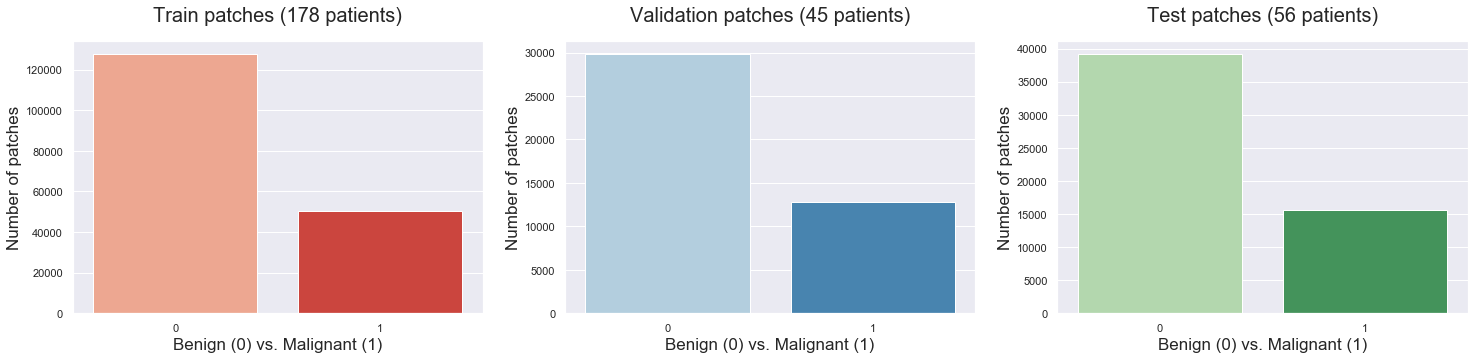

In [25]:
visualize_sets_distribution(df_train,df_val,df_test)

#### 2. Run model

In [ ]:
cb = CatBoostClassifier()
cb.fit(X_train,y_train)

In [26]:
cb = unpickle_file('saved-models/catboost_model')

In [27]:
y_pred = cb.predict(X_test)

Text(0.5, 1, 'Confusion matrix')

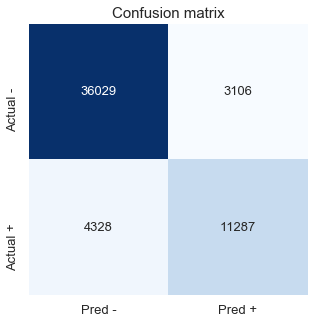

In [28]:
conf_mat = confusion_matrix(y_test,y_pred)

fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat,annot=True,annot_kws={'fontsize':13},cmap='Blues',fmt='g',cbar=False,ax=ax)
ax.set_ylim(2,0)
ax.set_yticklabels(['Actual -','Actual +'],fontsize=13)
ax.set_xticklabels(['Pred -','Pred +'],fontsize=13)
ax.set_title('Confusion matrix',fontsize=15)

In [29]:
print('Accuracy:',round(accuracy_score(y_test,y_pred)*100,2))
print('Recall:',round(recall_score(y_test,y_pred)*100,2))
print('Precision:',round(precision_score(y_test,y_pred)*100,2))
print('F1-Score:',round(f1_score(y_test,y_pred)*100,2))

Accuracy: 86.42
Recall: 72.28
Precision: 78.42
F1-Score: 75.23


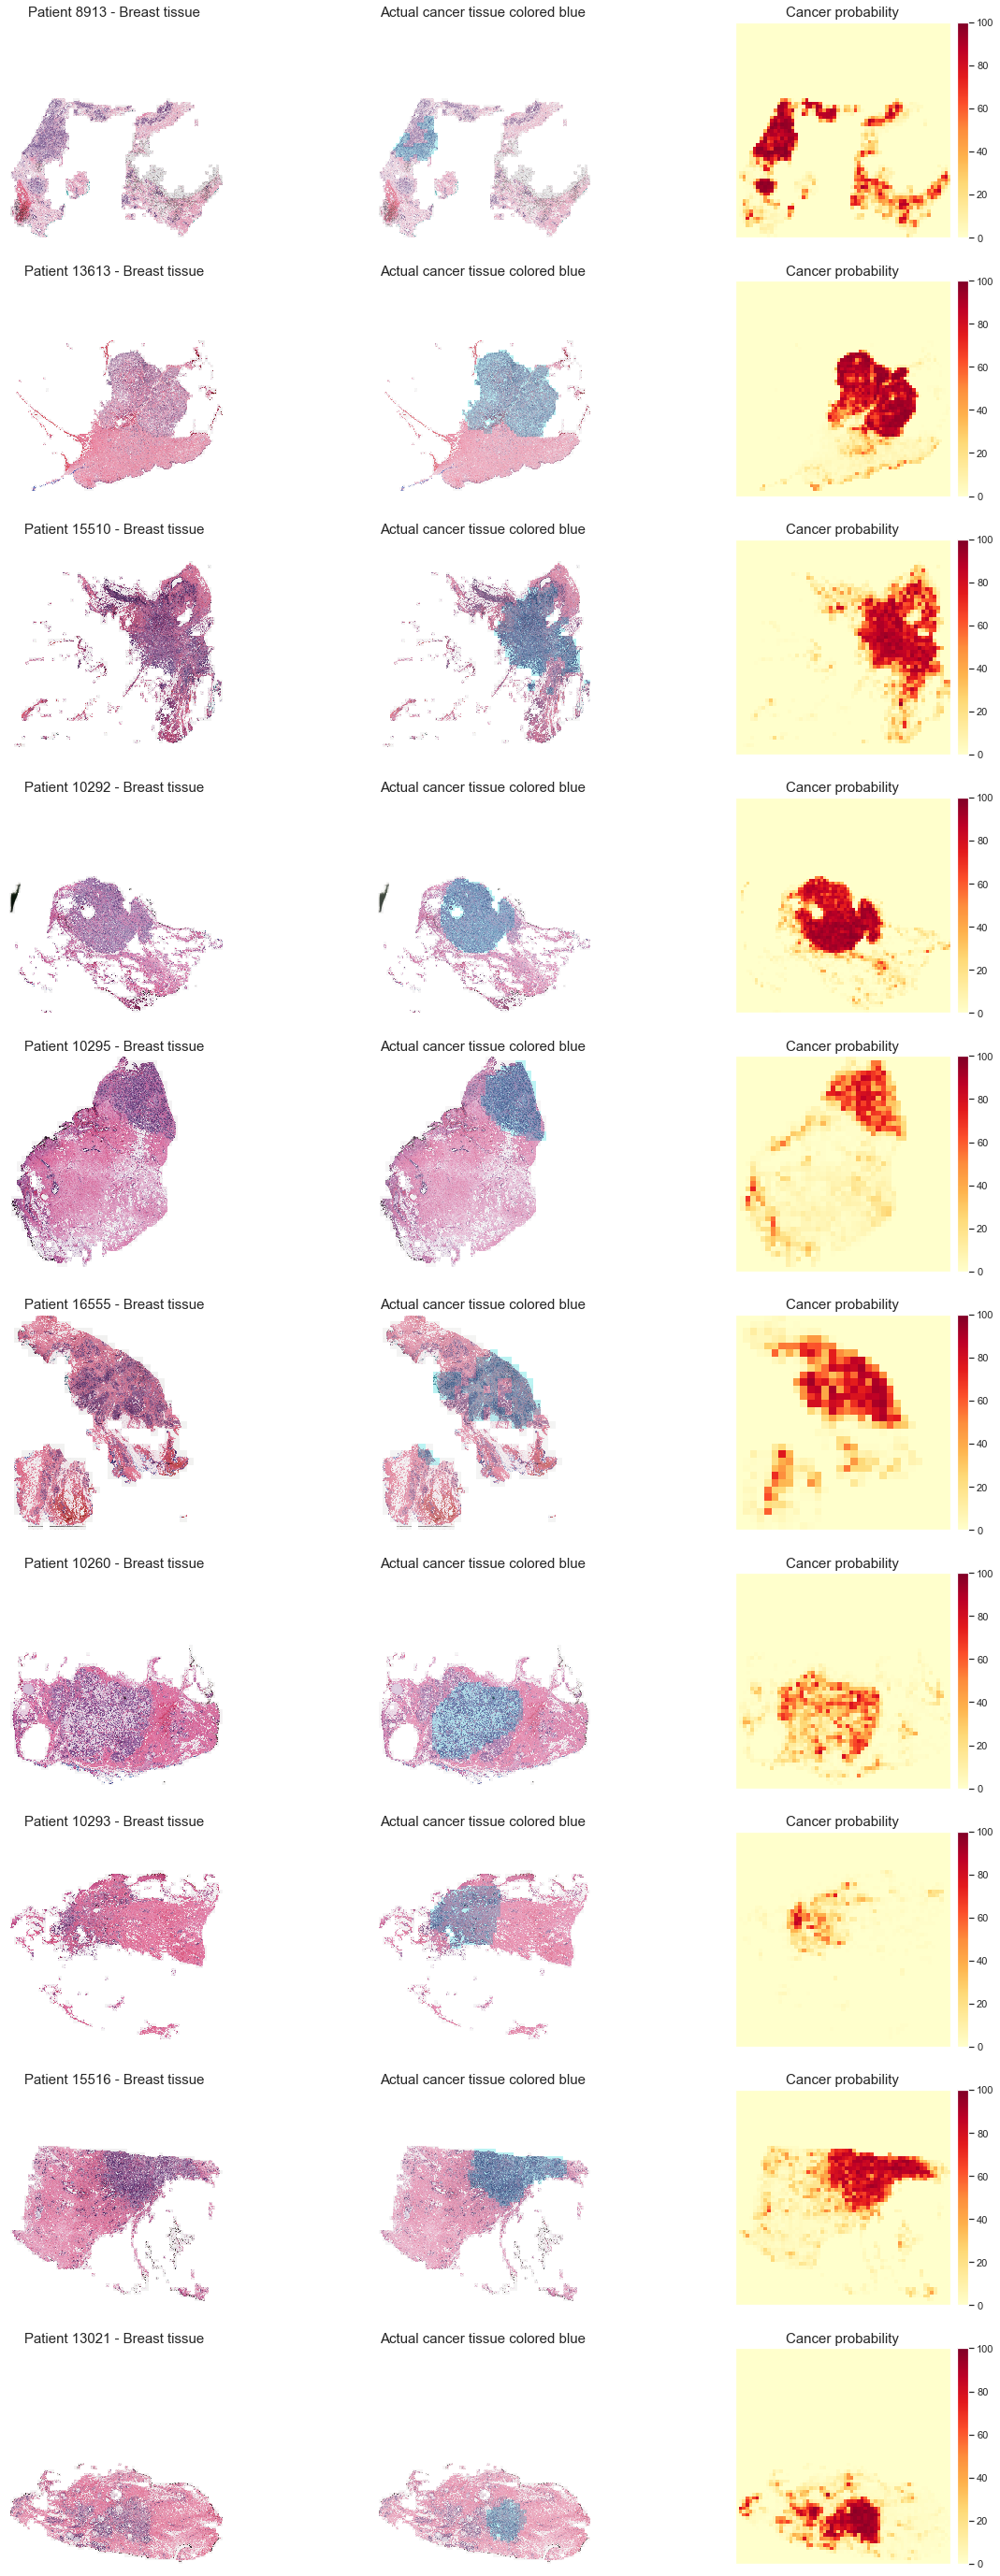

In [30]:
df_plot_test = test_patch_info.copy()
df_plot_test = pd.merge(df_plot_test,df,on=['patient_id','x_coord','y_coord'])
df_plot_test['cancer_proba'] = [proba[1] for proba in cb.predict_proba(X_test)]

visualize_model_results(df_plot_test)